In [5]:
! pip install --quiet langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph tavily-python langchain-mistralai gpt4all

# Corrective RAG

Self-reflection can enhance RAG, enabling correction of poor quality retrieval or generations.

Several recent papers focus on this theme, but implementing the ideas can be tricky.

Here we show how to implement self-reflective RAG using `Mistral` and `LangGraph`.

We'll focus on ideas from one paper, `Corrective RAG (CRAG)` [here](https://arxiv.org/pdf/2401.15884.pdf).

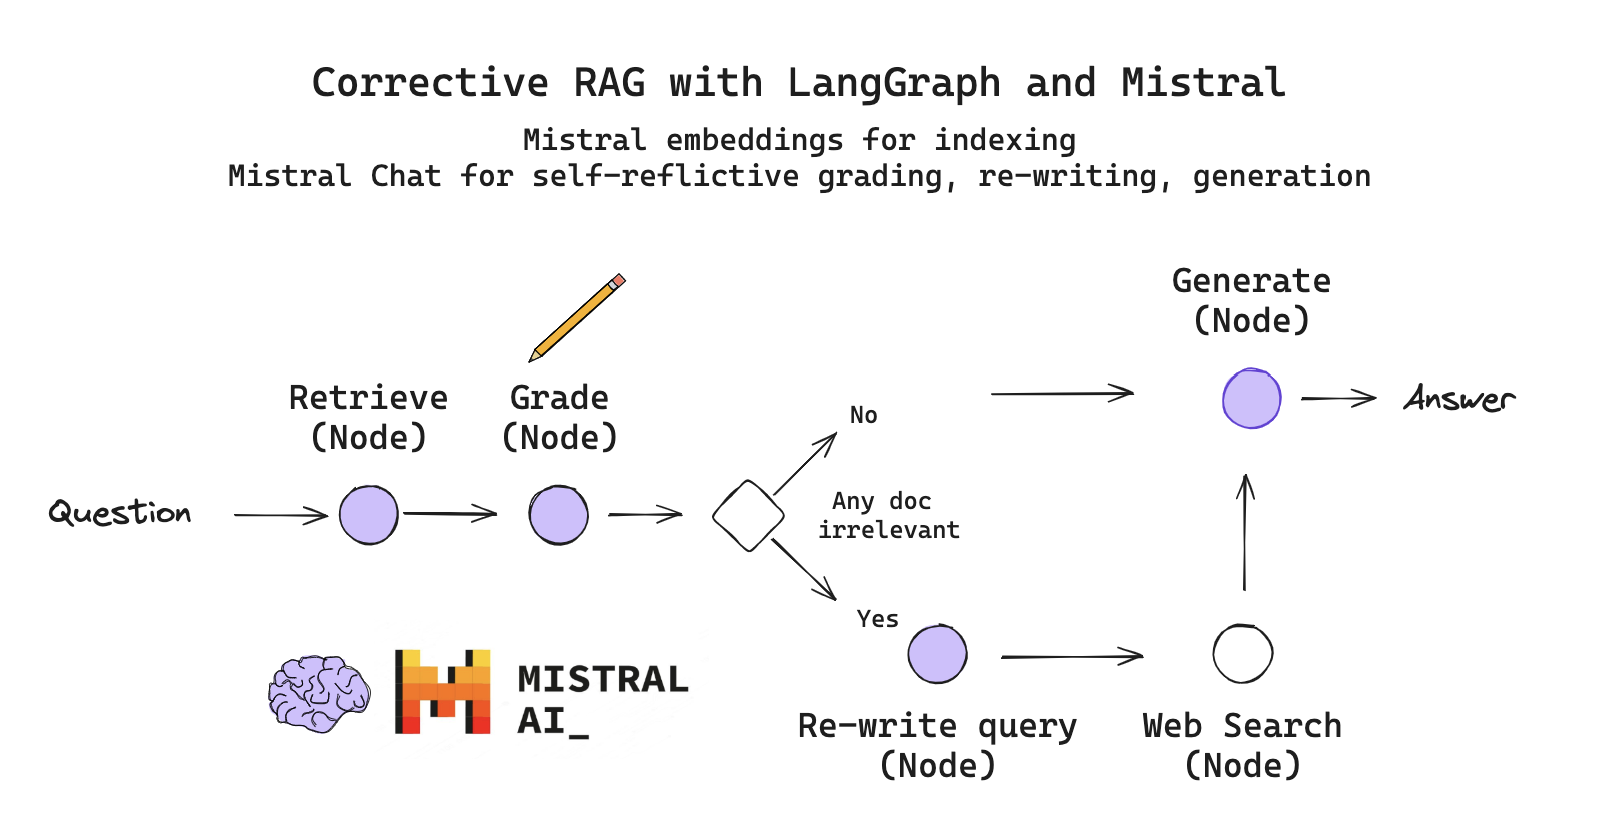

## Setup

### Using APIs 

* Set `MISTRAL_API_KEY` and set up Subscription to activate it.
* Set `TAVILY_API_KEY` to enable web search [here](https://app.tavily.com/sign-in).

### Using CoLab 

* [Here](https://colab.research.google.com/drive/1U5OcwWjoXZSud30q4XOk1UlIJNjaD3kX?usp=sharing) is a link to a CoLab for this notebook. 

### Running Locally 

If you want to run this locally (e.g., on your laptop), use [Ollama](https://ollama.ai/library/mistral/tags):

* Download [Ollama app](https://ollama.ai/).
* Download a `Mistral` model e.g., `ollama pull mistral:7b-instruct`, from various Mistral versions [here](https://ollama.ai/library/mistral) and Mixtral versions [here](https://ollama.ai/library/mixtral) available.
* Download LLaMA2 `ollama pull llama2:latest` to use Ollama embeddings.
* Set flags indicating we will run locally and the Mistral model downloaded:
  
```
run_local = "Yes"
local_llm = "mistral:7b-instruct"
```

### Tracing 

* Optionally, use [LangSmith](https://docs.smith.langchain.com/) for tracing (shown at bottom) by setting: 

```
export LANGCHAIN_TRACING_V2=true
export LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
export LANGCHAIN_API_KEY=<your-api-key>
```

In [6]:
# Check API keys
import os

mistral_api_key = os.environ.get("MISTRAL_API_KEY")
tavily_api_key = os.environ.get("TAVILY_API_KEY")

In [7]:
# Flags for running locally

run_local = "Yes"
local_llm = "mistral:instruct"

## Indexing

First, let's index a popular blog post on agents. 

We can use [Mistral embeddings](https://python.langchain.com/docs/integrations/text_embedding/mistralai).

For local, we can use [GPT4All](https://python.langchain.com/docs/integrations/text_embedding/gpt4all), which is a CPU optimized SBERT model [here](https://docs.gpt4all.io/gpt4all_python_embedding.html).

We'll use a local vectorstore, [Chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma).

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_mistralai import MistralAIEmbeddings
from langchain_community.embeddings import GPT4AllEmbeddings

# Load
url = "https://lilianweng.github.io/posts/2023-06-23-agent/"
loader = WebBaseLoader(url)
docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=100
)
all_splits = text_splitter.split_documents(docs)

# Embed and index
if run_local == "Yes":
    embedding = GPT4AllEmbeddings()
else:
    embedding = MistralAIEmbeddings(mistral_api_key=mistral_api_key)

# Index
vectorstore = Chroma.from_documents(
    documents=all_splits,
    collection_name="rag-chroma",
    embedding=embedding,
)
retriever = vectorstore.as_retriever()

bert_load_from_file: gguf version     = 2
bert_load_from_file: gguf alignment   = 32
bert_load_from_file: gguf data offset = 695552
bert_load_from_file: model name           = BERT
bert_load_from_file: model architecture   = bert
bert_load_from_file: model file type      = 1
bert_load_from_file: bert tokenizer vocab = 30522


## Corrective RAG

Let's implement self-reflective RAG with some ideas from the CRAG (Corrective RAG) [paper](https://arxiv.org/pdf/2401.15884.pdf):

* Grade documents for relevance relative to the question.
* If any are irrelevant, then we will supplement the context used for generation with web search.
* For web search, we will re-phrase the question and use Tavily API.
* We will then pass retrieved documents and web results to an LLM for final answer generation.

Here is a schematic of our graph in more detail:

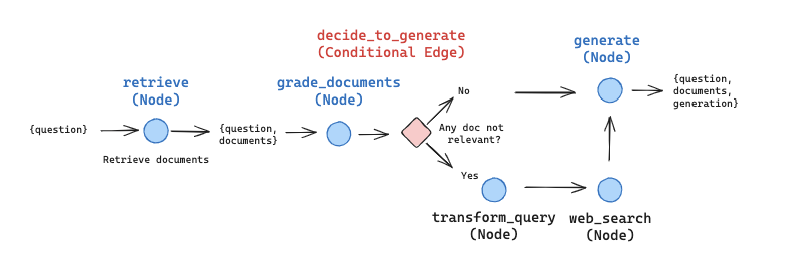

We will implement this using [LangGraph](https://python.langchain.com/docs/langgraph): 

* See video [here](https://www.youtube.com/watch?ref=blog.langchain.dev&v=pbAd8O1Lvm4&feature=youtu.be)
* See blog post [here](https://blog.langchain.dev/agentic-rag-with-langgraph/)

---

### State

Every node in our graph will modify `state`, which is dict that contains values (`question`, `documents`, etc) relevant to RAG.

In [9]:
from typing import Annotated, Dict, TypedDict

from langchain_core.messages import BaseMessage


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        keys: A dictionary where each key is a string.
    """

    keys: Dict[str, any]

### Nodes and Edges

Every node in the graph we laid out above is a function.

Each node will modify the state in some way.

Each edge will choose which node to call next.

In [10]:
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.schema import Document
from langchain_community.chat_models import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_mistralai.chat_models import ChatMistralAI

### Nodes ###


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    local = state_dict["local"]
    documents = retriever.get_relevant_documents(question)
    return {"keys": {"documents": documents, "local": local, "question": question}}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains generation
    """
    print("---GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    local = state_dict["local"]

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    if local == "Yes":
        llm = ChatOllama(model=local_llm, temperature=0)
    else:
        llm = ChatMistralAI(
            model="mistral-medium", temperature=0, mistral_api_key=mistral_api_key
        )

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {
        "keys": {"documents": documents, "question": question, "generation": generation}
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with relevant documents
    """

    print("---CHECK RELEVANCE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    local = state_dict["local"]

    # LLM
    if local == "Yes":
        llm = ChatOllama(model=local_llm, format="json", temperature=0)
    else:
        llm = ChatMistralAI(
            mistral_api_key=mistral_api_key, temperature=0, model="mistral-medium"
        )

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        score: str = Field(description="Relevance score 'yes' or 'no'")

    # Set up a parser + inject instructions into the prompt template.
    parser = PydanticOutputParser(pydantic_object=grade)

    from langchain_core.output_parsers import JsonOutputParser

    parser = JsonOutputParser(pydantic_object=grade)

    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keywords related to the user question, grade it as relevant. \n
        It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
        Provide the binary score as a JSON with no premable or explaination and use these instructons to format the output: {format_instructions}""",
        input_variables=["query"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    chain = prompt | llm | parser

    # Score
    filtered_docs = []
    search = "No"  # Default do not opt for web search to supplement retrieval
    for d in documents:
        score = chain.invoke(
            {
                "question": question,
                "context": d.page_content,
                "format_instructions": parser.get_format_instructions(),
            }
        )
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            search = "Yes"  # Perform web search
            continue

    return {
        "keys": {
            "documents": filtered_docs,
            "question": question,
            "local": local,
            "run_web_search": search,
        }
    }


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    local = state_dict["local"]

    # Create a prompt template with format instructions and the query
    prompt = PromptTemplate(
        template="""You are generating questions that is well optimized for retrieval. \n 
        Look at the input and try to reason about the underlying sematic intent / meaning. \n 
        Here is the initial question:
        \n ------- \n
        {question} 
        \n ------- \n
        Provide an improved question without any premable, only respond with the updated question: """,
        input_variables=["question"],
    )

    # Grader
    # LLM
    if local == "Yes":
        llm = ChatOllama(model=local_llm, temperature=0)
    else:
        llm = ChatMistralAI(
            mistral_api_key=mistral_api_key, temperature=0, model="mistral-medium"
        )

    # Prompt
    chain = prompt | llm | StrOutputParser()
    better_question = chain.invoke({"question": question})

    return {
        "keys": {"documents": documents, "question": better_question, "local": local}
    }


def web_search(state):
    """
    Web search based on the re-phrased question using Tavily API.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Web results appended to documents.
    """

    print("---WEB SEARCH---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    local = state_dict["local"]

    tool = TavilySearchResults()
    docs = tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"keys": {"documents": documents, "local": local, "question": question}}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer or re-generate a question for web search.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Next node to call
    """

    print("---DECIDE TO GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    filtered_documents = state_dict["documents"]
    search = state_dict["run_web_search"]

    if search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TRANSFORM QUERY and RUN WEB SEARCH---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

## Build Graph

The just follows the flow we outlined in the figure above.

In [11]:
import pprint

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

## Run

`Mistral API -` 

In [13]:
# Run
inputs = {
    "keys": {
        "question": "Explain how the different types of agent memory work?",
        "local": run_local,
    }
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value['keys']['generation'])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK RELEVANCE---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
"Node 'grade_documents':"
'\n---\n'
---DECIDE TO GENERATE---
---DECISION: TRANSFORM QUERY and RUN WEB SEARCH---
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
"Node '__end__':"
'\n---\n'
('Episodic memory stores specific events or experiences, making them unique to '
 'each individual. Semantic memory, on the other hand, involves general '
 'knowledge and facts that are not tied to personal experiences. Procedural '
 'memory is responsible for learning and remembering sequences of actions, '
 "such as riding a bike. These memory types contribute to an agent's learning "
 'and decision-making processes by allowing it to recall past experiences '
 '(episodic), understand and use information (sema

`Locall (Ollama) -` 

In [13]:
# Run
inputs = {
    "keys": {
        "question": "Explain how the different types of agent memory work?",
        "local": run_local,
    }
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value['keys']['generation'])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK RELEVANCE---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
"Node 'grade_documents':"
'\n---\n'
---DECIDE TO GENERATE---
---DECISION: GENERATE---
---GENERATE---
"Node 'generate':"
'\n---\n'
"Node '__end__':"
'\n---\n'
(' In an LLM (large language model)-powered autonomous agent system, LLM '
 'functions as the agent’s brain, complemented by several key components: '
 'planning and memory.\n'
 '\n'
 'Planning involves breaking down large tasks into smaller subgoals for '
 'efficient handling of complex tasks and self-criticism and refinement to '
 'improve results.\n'
 '\n'
 'Memory includes short-term memory, which utilizes in-context learning, and '
 'long-term memory, providing the agent with the capability to retain and '
 'recall information over extended periods using an external vector store and '
 'fast retrieval. The agent also learns to call externa

## LangSmith Traces

`Mistral API -` 

https://smith.langchain.com/public/1c9ce3f2-76bb-4514-a107-076823e9849e/r

`Locall (Ollama) -` 

https://smith.langchain.com/public/fd650c43-b0e9-48f4-8cb7-ca77c736d10d/r